## setup

In [41]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from langchain.schema import SystemMessage, HumanMessage

from typing import TypedDict, List
import pandas as pd
from pydantic import BaseModel, Field


load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

if not GROQ_API_KEY:
    raise ValueError("Missing GROQ_API_KEY in .env")


## AI PROMPT

In [42]:

# AI Prompt using LangChain PromptTemplate
LLM_SYSTEM_PROMPT = """
Role Definition:
You are a an expert Software QA Leader with 10 years experience in saas sase environments.

QA Instructions:
Ensure all field content is precise, actionable, and professional.
Follow the schema exactly: test_case_id, test_title, description, preconditions, test_steps, test_data, expected_result, comments.
Do not add extra fields or text outside the schema.

"""


## Setup test case and test plan structure

In [43]:
class TestCase(BaseModel):
    test_case_id: int = Field(..., description="Unique identifier for the test case.")
    test_title: str = Field(..., description="Title of the test case.")
    description: str = Field(..., description="Detailed description of what the test case covers.")
    preconditions: str = Field(..., description="Any setup required before execution.")
    test_steps: str = Field(..., description="Step-by-step execution guide.")
    test_data: str = Field(..., description="Input values required for the test.")
    expected_result: str = Field(..., description="The anticipated outcome.")
    comments: str = Field(..., description="Additional notes or observations.")

class TestPlan(BaseModel):
    test_cases: List[TestCase]


## Setup structured llm with Groq

In [44]:
# Wrap LLM with structured output
structured_llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=GROQ_API_KEY
)
llm_with_structured_output = structured_llm.with_structured_output(TestPlan)

## Set graph state

In [45]:
class TestGenState(TypedDict):
    requirement: str
    test_plan: List[dict]


## Define the nodes

In [46]:

def parse_requirement(state: TestGenState) -> TestGenState:
    """
    Node: Parse Requirement
    Purpose: Prepare the requirement text for the LLM.
    Input: state['requirement'] (string)
    Output: state['requirement'] (string)
    """
    with open("..\\data\\requirements.txt", "r") as f:
        state["requirement"] = f.read()
    return state

def generate_test_cases(state: TestGenState) -> TestGenState:
    """Generate structured test cases directly from requirement text."""
    messages = [
    SystemMessage(content=LLM_SYSTEM_PROMPT),
    HumanMessage(content=state["requirement"])
]
    resp = llm_with_structured_output.invoke(messages) 
    print(resp)
    # resp is already a TestPlan object
    state["test_plan"] = [tc.dict() for tc in resp.test_cases]
    return state


def export_tests(state: TestGenState, file_path="test_cases.csv") -> TestGenState:
    """Node: Export all tests to CSV and display DataFrame."""
    df = pd.DataFrame(state.get("test_plan", []))
    df.to_csv(file_path, index=False)
    display(df)
    state["exported_file"] = file_path
    return state



## setup the graph

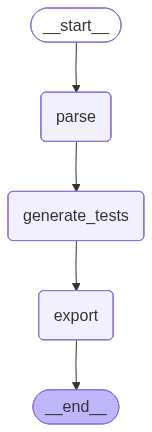

In [47]:
workflow = StateGraph(TestGenState)
workflow.add_node("parse", parse_requirement)
workflow.add_node("generate_tests", generate_test_cases)
workflow.add_node("export", export_tests)

workflow.set_entry_point("parse")

# Normal flow
workflow.add_edge("parse", "generate_tests")
workflow.add_edge("generate_tests", "export")


workflow.add_edge("export", END)

app = workflow.compile()
app

## Invoke the Graph

In [48]:
result = app.invoke({})



test_cases=[TestCase(test_case_id=1, test_title='Copy Sensitive Data from Protected Application', description='Verify that copying sensitive data from a protected application is blocked or logged.', preconditions='Sensitive data is present in the protected application.', test_steps='1. Launch the protected application with sensitive data.\n2. Attempt to copy the sensitive data.\n3. Verify that the copy action is blocked or logged.', test_data='Sensitive data (e.g., credit card numbers, PII, source code)', expected_result='Copy action is blocked or logged with user ID, application, timestamp, and data type.', comments='Verify that the copy action is blocked or logged with accurate details.'), TestCase(test_case_id=2, test_title='Paste Sensitive Data into Unauthorized Destination', description='Verify that pasting sensitive data into an unauthorized destination is blocked and generates an alert.', preconditions='Sensitive data is present in the clipboard and an unauthorized destination i

C:\Users\user\AppData\Local\Temp\ipykernel_10028\1229044405.py:21: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  state["test_plan"] = [tc.dict() for tc in resp.test_cases]


,test_case_id,test_title,description,preconditions,test_steps,test_data,expected_result,comments
0,1,Copy Sensitive Data from Protected Application,Verify that copying sensitive data from a prot...,Sensitive data is present in the protected app...,1. Launch the protected application with sensi...,"Sensitive data (e.g., credit card numbers, PII...","Copy action is blocked or logged with user ID,...",Verify that the copy action is blocked or logg...
1,2,Paste Sensitive Data into Unauthorized Destina...,Verify that pasting sensitive data into an una...,Sensitive data is present in the clipboard and...,1. Copy sensitive data from a protected applic...,"Sensitive data (e.g., credit card numbers, PII...",Paste action is blocked and generates an alert...,Verify that the paste action is blocked and ge...
2,3,Approved Application Copy/Paste,Verify that approved applications allow copy/p...,Approved application is open with sensitive data.,1. Launch an approved application with sensiti...,"Approved application (e.g., internal CRM, tick...",Copy and paste actions are allowed without fal...,Verify that approved applications allow copy/p...
3,4,Exceptions Configuration,Verify that exceptions are configurable for sp...,Exceptions configuration is enabled.,1. Configure exceptions for specific users or ...,"Exceptions configuration (e.g., specific users...",Exceptions are applied correctly with business...,Verify that exceptions are configurable for sp...
4,5,Accuracy and Performance,Verify that the DLP policy detects sensitive d...,Sensitive data is present in the protected app...,1. Launch the protected application with sensi...,"Sensitive data (e.g., credit card numbers, PII...",Detection accuracy ≥ 95% and ≤ 3% false positi...,Verify that the DLP policy detects sensitive d...
5,6,Compliance,Verify that the DLP policy aligns with organiz...,Sensitive data is present in the protected app...,1. Launch the protected application with sensi...,"Sensitive data (e.g., credit card numbers, PII...",DLP policy aligns with organizational data cla...,Verify that the DLP policy aligns with organiz...
